In [3]:
import os
import random
from os import path
from time import time

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as functional
from PIL import Image
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA is available: ", torch.cuda.is_available())

CUDA is available:  True


# 1. 데이터셋 준비하기

In [4]:
class ImageTransform:
    def __init__(self, resize, _mean, _std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(_mean, _std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(_mean, _std)
            ])
        }

    def __call__(self, _img, phase):
        return self.data_transform[phase](_img)

In [5]:
cat_dir = r"../data/dogs-vs-cats/cat"
dog_dir = r"../data/dogs-vs-cats/dog"

cat_path = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_path = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])

img_paths = [*cat_path, *dog_path]
corrct_img_paths = [i for i in img_paths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(corrct_img_paths)

TRAIN_DATA_SIZE = 400

train_img_paths = corrct_img_paths[:TRAIN_DATA_SIZE]
val_img_paths = corrct_img_paths[TRAIN_DATA_SIZE:-10]
test_img_paths = corrct_img_paths[-10:]

print(f"학습 데이터셋 : {len(train_img_paths)}개")
print(f"검증 데이터셋 : {len(val_img_paths)}개")
print(f"테스트 데이터셋 : {len(test_img_paths)}개")

학습 데이터셋 : 400개
검증 데이터셋 : 92개
테스트 데이터셋 : 10개


# 2. 데이터셋 살펴보기

In [6]:
def display_image_grid(path_of_imgs, pred_labels=(), cols=5):
    rows = len(path_of_imgs) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, img_path in enumerate(path_of_imgs):
        _img = cv2.imread(img_path)
        _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

        true_label = path.normpath(img_path).split(path.sep)[-len(path.sep)]
        pred_label = pred_labels[i] if pred_labels else true_label

        color = "green" if true_label == pred_label else "red"

        ax.ravel()[i].imshow(_img)
        ax.ravel()[i].set_title(pred_label, color=color)
        ax.ravel()[i].set_axis_off()

    plt.tight_layout()
    plt.show()

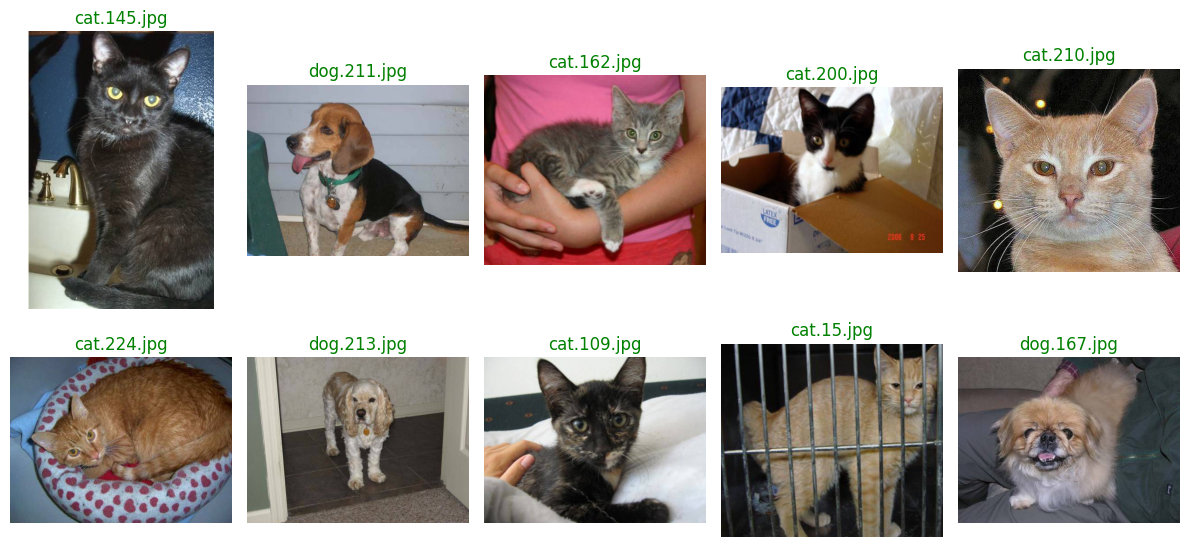

In [7]:
display_image_grid(test_img_paths)

# 3. 데이터셋 클래스 만들기

In [8]:
class DogOrCatDataset(Dataset):
    def __init__(self, file_list, _transform=None, phase='train'):
        self.file_list = file_list
        self.transform = _transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        _img = Image.open(img_path)
        img_transformed = self.transform(_img, self.phase)

        label = img_path.split(path.sep)[-len(path.sep)].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [9]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [10]:
train_dataset = DogOrCatDataset(train_img_paths, ImageTransform(size, mean, std), 'train')
val_dataset = DogOrCatDataset(val_img_paths, ImageTransform(size, mean, std), 'val')

index = 0

print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0])


# 4. 모델 구축하기

In [12]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # 224 -> 55
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 55 -> 27
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 27 -> 27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 27 -> 13
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 13 -> 13
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 13 -> 13
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 13 -> 13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 13 -> 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # 배치를 제외한 모든 차원을 평탄화(flatten)함
        x = self.classifier(x)
        return x

In [13]:
model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [15]:
def count_params(_model):
    return sum(p.numel() for p in _model.parameters() if p.requires_grad)


print("Number of parameters: ", count_params(model))

Number of parameters:  42321218


# 5. 모델 학습하기

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [17]:
def train_model(_model, d_loader_dict, crit, opti, n_epo):
    since = time()
    best_acc = 0.0

    for epoch in range(n_epo):
        print("Epoch {}/{}".format(epoch + 1, n_epo))
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                _model.train()
            else:
                _model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for _inputs, _labels in tqdm(d_loader_dict[phase]):
                _inputs = _inputs.to(device)
                _labels = _labels.to(device)

                opti.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outs = _model(_inputs)
                    loss = crit(outs, _labels)
                    _, _preds = torch.max(outs, 1)

                    if phase == "train":
                        loss.backward()
                        opti.step()

                    epoch_loss += loss.item() * _inputs.size(0)
                    # noinspection PyTypeChecker
                    epoch_corrects += torch.sum(_preds == _labels.data)

            epoch_loss = epoch_loss / len(d_loader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(d_loader_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc

    time_elapsed = time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:.4f}".format(best_acc))
    return _model

> 아래 블록을 실행할 때마다 추가로 학습됩니다.

In [18]:
num_epoch = 10

train = True

PT_NAME = "idoc-alex.pt"

if path.exists(PT_NAME):  # Is Dog Or Cat
    model.load_state_dict(torch.load(PT_NAME))
    print("Model loaded.")

if train:
    model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Model loaded.
Epoch 1/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5109
Epoch 2/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5109
Epoch 3/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5109
Epoch 4/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6916 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5109
Epoch 5/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6918 Acc: 0.5109
Epoch 6/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6918 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6917 Acc: 0.5109
Epoch 7/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6917 Acc: 0.5109
Epoch 8/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6917 Acc: 0.5109
Epoch 9/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6918 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6916 Acc: 0.5109
Epoch 10/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6916 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6915 Acc: 0.5109
Training complete in 0m 23s
Best val Acc: 0.5109


In [19]:
save_model = True
if save_model:
    torch.save(model.state_dict(), PT_NAME)
    print("Model saved.")

Model saved.


# 6. 모델 평가하기

In [20]:
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_img_paths):
        img = Image.open(test_path)
        _id = test_path.split(path.sep)[-1].split('.')[1]

        transform = ImageTransform(size, mean, std)
        img = transform(img, 'val').unsqueeze(0).to(device)

        model.eval()
        outputs = model(img)
        preds = functional.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
res = pd.DataFrame({"id": id_list, "label": pred_list})

res.sort_values(by="id", inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv("test-alex.csv", index=False)

res.head(10)

,id,label
0,109,0.511614
1,145,0.508357
2,15,0.509304
3,162,0.511262
4,167,0.508974
5,200,0.514931
6,210,0.513408
7,211,0.511957
8,213,0.509489
9,224,0.508894


In [22]:
class_ = classes = {0: "cat", 1: "dog"}


def show_img_grid(_img_paths, cols=5):
    rows = len(_img_paths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, img_path in enumerate(_img_paths):
        _img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        a = random.choice(res["id"].values)
        label = res.loc[res["id"] == a, "label"].values[0]

        if label > 0.5:
            label = 1  # 0.5 이상 -> dog
        else:
            label = 0  # 0.5 미만 -> cat

        ax.ravel()[i].imshow(_img)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

# 7. 예측한 결과 확인하기

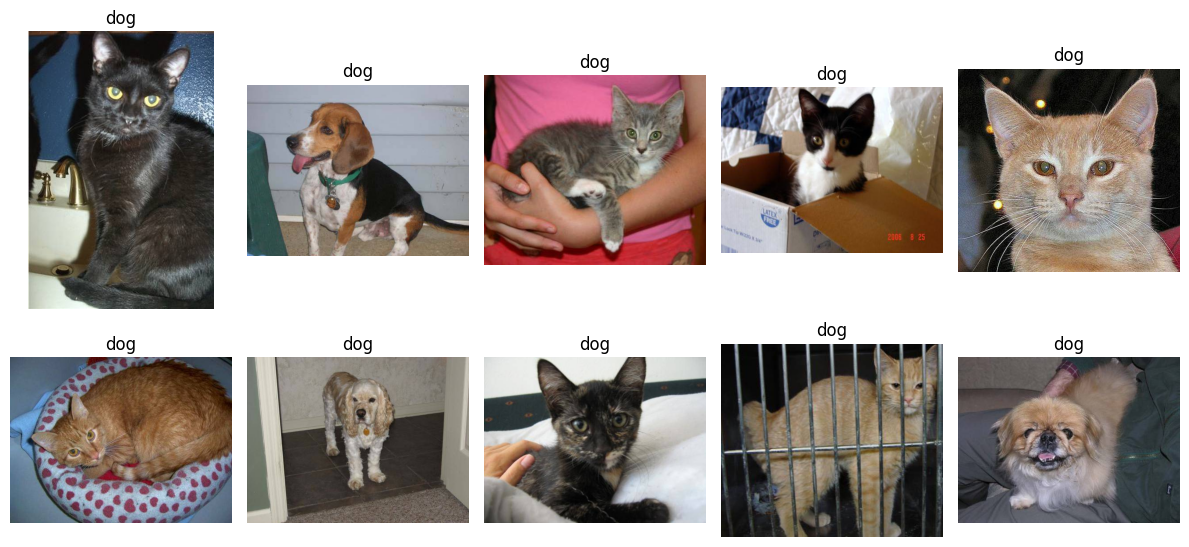

In [23]:
show_img_grid(test_img_paths)